In [ ]:
#please cite the following paper:
#Kakavand, R., Palizi, M., Tahghighi, P. et al. 
#Integration of Swin UNETR and statistical shape modeling for a semi-automated segmentation of the knee and biomechanical modeling of articular cartilage. 
#Sci Rep 14, 2748 (2024). https://doi.org/10.1038/s41598-024-52548-9

In [7]:
# install these packages
import torch 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
from tqdm import tqdm
from monai.networks.nets.swin_unetr import SwinUNETR
from torchvision.ops.focal_loss import sigmoid_focal_loss
from torch.utils.data import DataLoader
import SimpleITK as sitk

In [2]:
from utility import dice_loss
import config
from dataset import KneeDataset

In [8]:
num_mris=1 #number of images to segment
path_t_mri=r'D:\bone_seg\9002430.nii.gz'# MRI address
path_mode=r'D:\bone_seg\Femurbest_model_fold_ 3.ckpt'#model address

In [9]:
torch.multiprocessing.set_sharing_strategy('file_system')
PYTORCH_NO_CUDA_MEMORY_CACHING=1

def loss_func(pred, mask):
    bce_loss = sigmoid_focal_loss(pred.squeeze(dim=1), mask.float(), reduction="mean");
    d_loss = dice_loss(pred, mask, sigmoid=True, arange_logits=True, spatial_dims=3);
    return bce_loss + d_loss, 1-d_loss;

def train_one_epoch(epoch, model, optimizer, loader, scaler):
    epoch_loss = [];
    epoch_dice = [];

    pbar = enumerate(loader);
    print(('\n' + '%10s'*3) %('Epoch', 'Loss', 'Dice'));
    pbar = tqdm(pbar, total= len(loader), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

    for batch_idx, (mri, mask) in pbar:
        mri, mask = mri.to(config.DEVICE), mask.to(config.DEVICE)
        
        #with torch.cuda.amp.autocast_mode.autocast():
        pred = model(mri.unsqueeze(dim=1));
        loss,dice = loss_func(pred, mask);
        loss = loss / config.VIRTUAL_BATCH_SIZE;

        scaler.scale(loss).backward();
        epoch_loss.append(loss.item());
        epoch_dice.append(dice.item());

        if ((batch_idx+1) % config.VIRTUAL_BATCH_SIZE == 0) or (batch_idx+1 == len(loader)):
            scaler.step(optimizer);
            scaler.update();
            model.zero_grad(set_to_none = True);
            #scaler.update();

        pbar.set_description(('%10s' + '%10.4g'*2) %(epoch, np.mean(epoch_loss), np.mean(epoch_dice)));

    return np.mean(epoch_loss), np.mean(epoch_dice);

def valid_one_epoch(epoch, model, loader, metrics):
    epoch_loss = [];
    epoch_prec = [];
    epoch_rec = [];
    epoch_f1 = [];

    pbar = enumerate(loader);
    print(('\n' + '%10s'*5) %('Epoch', 'Loss', 'Precision', 'Recal', 'F1'));
    pbar = tqdm(pbar, total= len(loader), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

    with torch.no_grad():
        for batch_idx, (mri, mask) in pbar:
            mri, mask = mri.to(config.DEVICE), mask.to(config.DEVICE)

            #with torch.cuda.amp.autocast_mode.autocast():
            pred = model(mri.unsqueeze(dim=1));
            pred = torch.sigmoid(pred);
            loss,dice = loss_func(pred, mask);
            loss = loss/config.VIRTUAL_BATCH_SIZE;
            prec = metrics[0](pred.squeeze(dim=1), mask);
            rec = metrics[1](pred.squeeze(dim=1), mask);
            f1 = metrics[2](pred.squeeze(dim=1), mask);

           
            epoch_loss.append(loss.item());
            epoch_prec.append(prec.item());
            epoch_rec.append(rec.item());
            epoch_f1.append(f1.item());

            pbar.set_description(('%10s' + '%10.4g'*4) %(epoch, np.mean(epoch_loss), np.mean(epoch_prec), np.mean(epoch_rec), np.mean(epoch_f1)));

    return np.mean(epoch_loss), [np.mean(epoch_prec), np.mean(epoch_rec), np.mean(epoch_f1)];



def predict(model):
    img=[]
    mask=[]
    for i in range (0,num_mris):
        img.append(path_t_mri)
        #img.append(path_t_mri[i]) if more than one image
        # mask.append(path_t_mask)#uncomment this if you have a mask

    mri = KneeDataset(img,img, train = False); #you can replace the second img with a mask for comparison
    mri_loader = DataLoader(mri, num_workers=0, shuffle = False, batch_size=1, drop_last=False, pin_memory=True);
    pbar = enumerate(mri_loader);
    pbar = tqdm(pbar, total= len(mri_loader), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    
    with torch.no_grad():
        pred_t=np.zeros((num_mris, 1, 1, 160, 128, 128))
        # mri = mri.to(config.DEVICE)
        for batch_idx, (mri1, mask1) in pbar:
            # mri1, mask1 = mri1.to(config.DEVICE), mask1.to(config.DEVICE) #uncomment this if you need to use GPU
            mri1, mask1 = mri1, mask1
            print('MRI size=',np.shape(mri1))
        #that is the prediction for the mri
            pred=model(mri1.unsqueeze(dim=1));
        
            pred = torch.sigmoid(pred);
            pred=pred>0.5
        #this is the numpy array of the prediction,
        #you can use this one to visualize the prediction of the model
            pred = pred.detach().cpu().numpy();
            pred_t[batch_idx,...]=pred
            print('Prediction size=',np.shape(pred_t))

    
    return pred_t ,mri1 
pre_test=[]
if __name__ == "__main__":

    model = SwinUNETR(img_size=96, in_channels=1, out_channels=1, feature_size=48);
    
    d = pickle.load(open(path_mode, 'rb'));
    model.load_state_dict(d());
    # Model=model.to("cuda")  #uncomment this if you need to use GPU

    #MAKE SURE THE MODEL IS IN EVAL STATE
    model.eval();
    out_pre=predict(model)
    pre_test=out_pre[0]
    mri=out_pre[1];


  0%|          | 0/1 [00:00<?, ?it/s]

MRI size= (1, 160, 128, 128)


100%|██████████| 1/1 [00:10<00:00, 10.40s/it]

Prediction size= (1, 1, 1, 160, 128, 128)


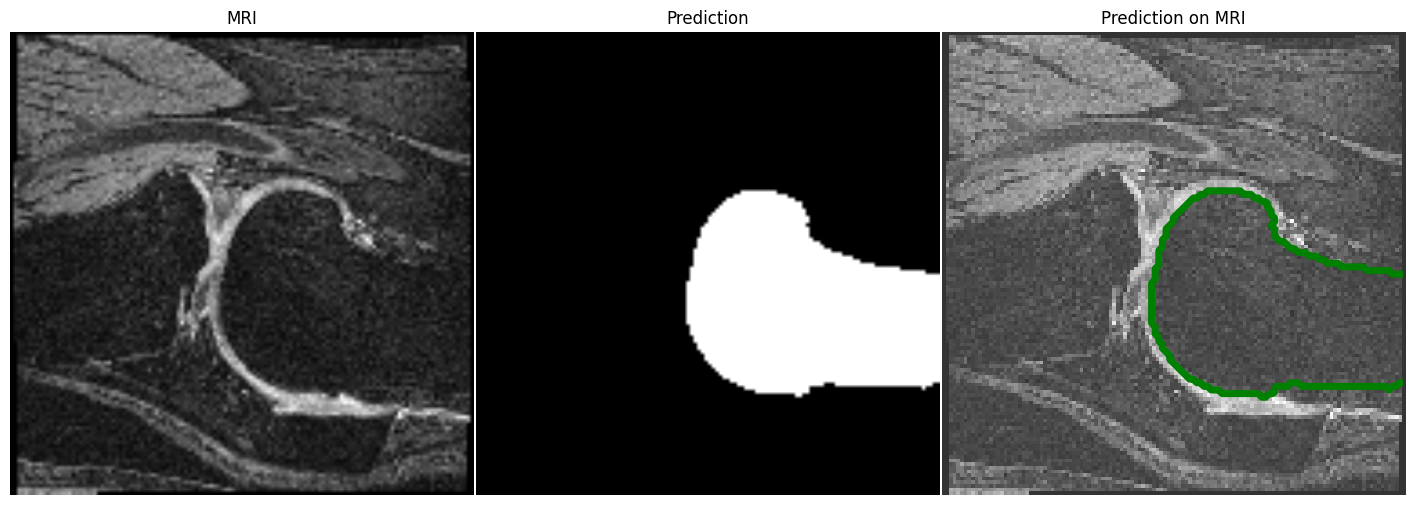

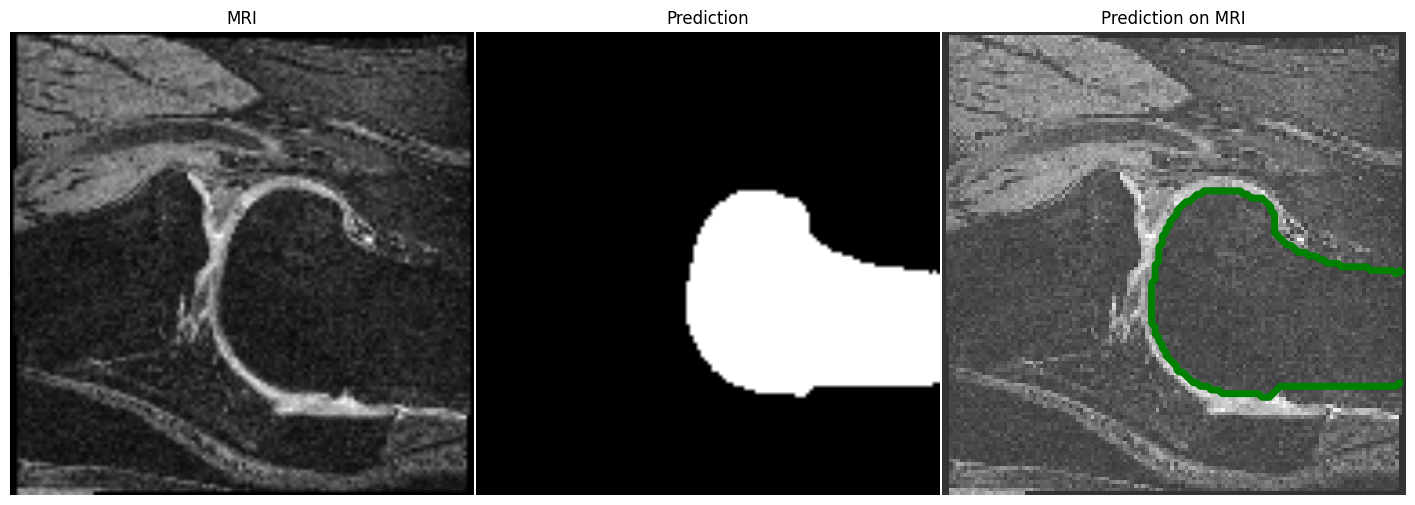

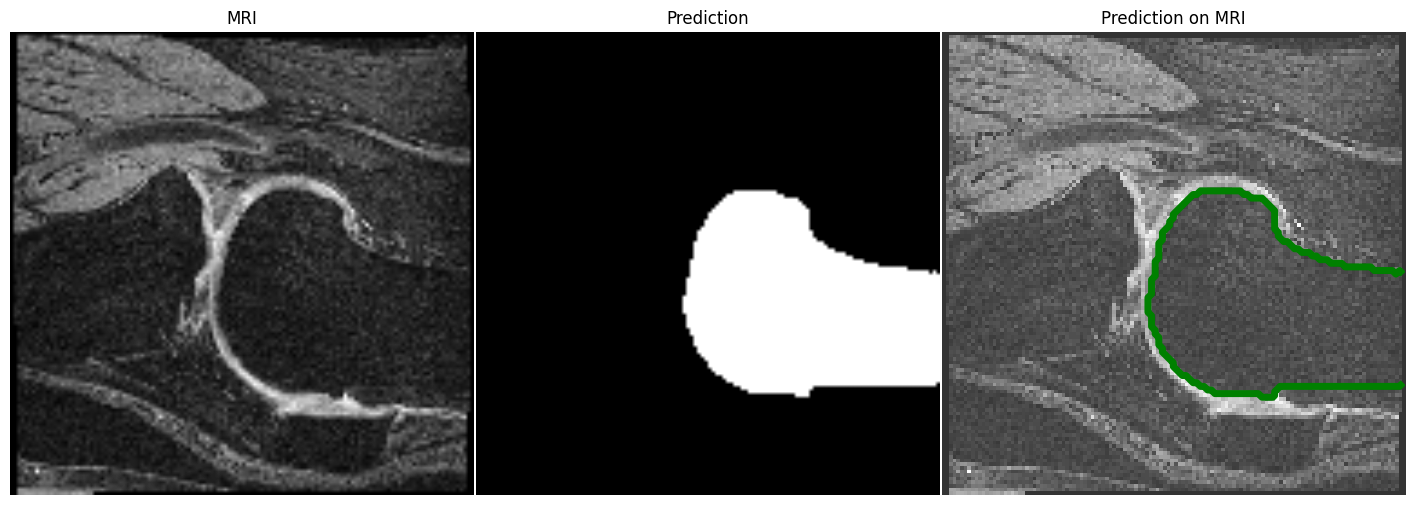

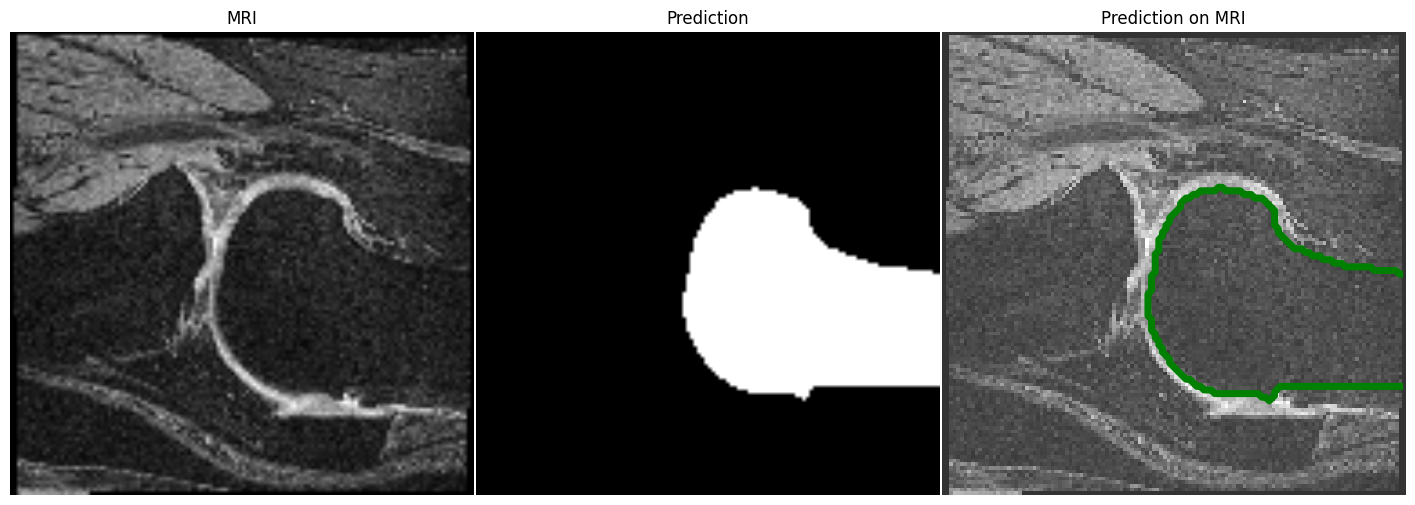

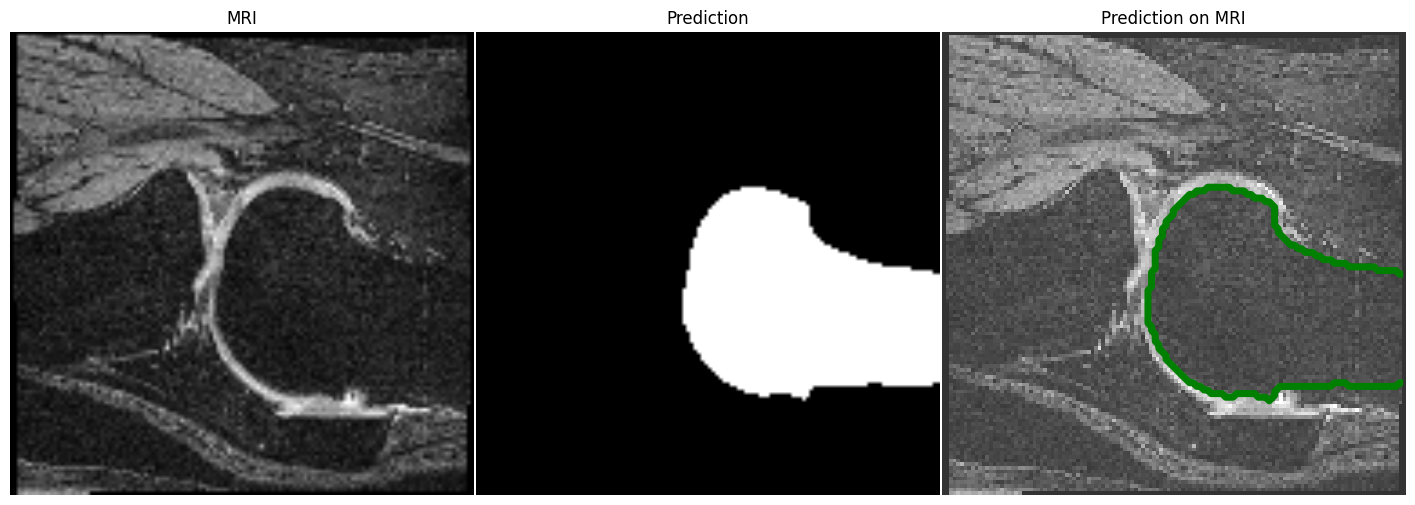

In [11]:
for i in range (100,105):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 9),gridspec_kw={'wspace':0.005, 'hspace':0.005},frameon=False)
    ax1.imshow(mri[0,i , :, :], cmap = 'gray', interpolation = 'bilinear')
    ax1.set_title('MRI')
    ax1.axis('off')
    ax2.imshow(pre_test[0,0,0,i,:,:], cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Prediction')
    ax2.axis('off')
    ax3.contour(pre_test[0,0,0,i,:,:], colors = 'g', linewidths = 5, levels = [0.5])
    ax3.imshow(mri[0,i , :, :], cmap = 'gray', interpolation = 'none',alpha=0.8)
    ax3.set_title('Prediction on MRI')
    ax3.axis('off')


In [12]:
# a function to save the numpy array
def save_DICOM(i,numpy_pred,path):
    img1 = sitk.GetImageFromArray(numpy_pred)
    img1.SetOrigin([-114.623, -57.5773,-80.2892])#you can set the origin of the shape here
    img1.SetSpacing([0.364583, 0.364583,0.7])# set spacing here
    sitk.WriteImage(img1, path+'//'+'Prediction_num_'+str(i)+".dcm")

In [13]:
# this will adjust the prediction slices with the original MRI
MRI_size_H=384
MRI_size_D=160
for m in range (0,num_mris):
    pre01=pre_test[m, 0,0,:, :, :]
    pre011=np.zeros((MRI_size_D,MRI_size_H,MRI_size_H))
    pre022=np.zeros((MRI_size_D,MRI_size_H,MRI_size_H))
    for i in range (0,MRI_size_D):
        imgt1=pre01[MRI_size_D-1-i,:,:]
        pre011[i,:,:]=cv2.resize(imgt1,dsize=(MRI_size_H,MRI_size_H),interpolation=cv2.INTER_CUBIC)
    for i in range (0,MRI_size_H):
        imgt1=pre011[:,:,i]
        pre022[:,:,i]=cv2.resize(imgt1,dsize=(MRI_size_H,MRI_size_D),interpolation=cv2.INTER_CUBIC)
    for ii in range (0,MRI_size_D):
        for jj in range (0,MRI_size_H):
            for kk in range(0,MRI_size_H):
                if pre022[ii,jj,kk]>=0.5:
                    pre022[ii,jj,kk]=1
    pre022=pre022.astype(np.uint8)
    path=r'D:\bone_seg'; #address to save the mri
    save_DICOM(m,pre022,path)
